In [2]:
#import libraries
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn

In [3]:
import pandas as pd

In [4]:
from datasets import load_dataset

emotion_data = load_dataset('emotion')
emotion_data.set_format(type='pandas')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
df = emotion_data['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [6]:
labels = emotion_data['train'].features['label'].names
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [7]:
df['class'] = df['label'].apply(lambda x: labels[x])

In [8]:
df.head()

,text,label,class
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [9]:
import matplotlib.pyplot as plt

In [10]:
label_grup = df['class'].value_counts(ascending = True)
label_grup

,count
class,
surprise,572
love,1304
fear,1937
anger,2159
sadness,4666
joy,5362


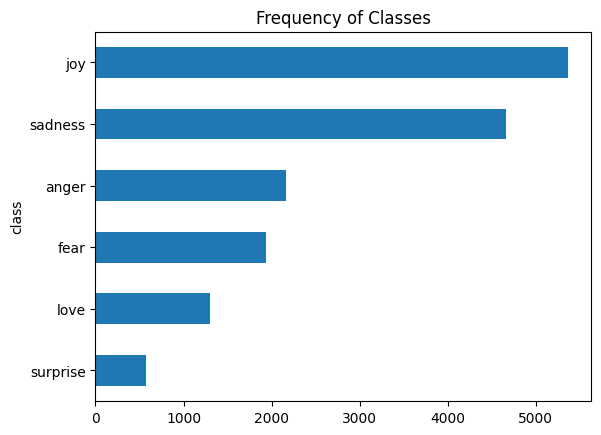

In [11]:
label_grup.plot.barh()
plt.title('Frequency of Classes')
plt.show()

In [12]:
df['word count'] = df['text'].str.split().apply(len)

<Axes: title={'center': 'word count'}, xlabel='class'>

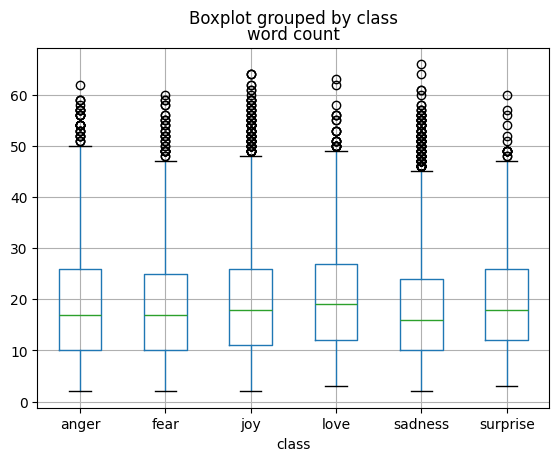

In [13]:
df.boxplot('word count', by='class')

now we will convert text to tokens so that we can work with transformers

In [14]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [15]:
text = "Daata Science and machine learning!. Tokenization is awesome"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 4830, 6790, 2671, 1998, 3698, 4083, 999, 1012, 19204, 3989, 2003, 12476, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [16]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'da', '##ata', 'science', 'and', 'machine', 'learning', '!', '.', 'token', '##ization', 'is', 'awesome', '[SEP]']


In [17]:
tokenizer.vocab_size, tokenizer.model_max_length

(30522, 512)

Tokenization of data

In [18]:
emotion_data.reset_format()

In [19]:
def tokenize(batch):
  temp =tokenizer(batch['text'], padding=True, truncation=True)
  return temp

In [20]:
print(tokenize(emotion_data["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [21]:
emotions_encoded = emotion_data.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [22]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

Model Building

In [23]:
inputs = tokenizer(text, return_tensors='pt') #return as pytorch tensor
inputs

{'input_ids': tensor([[  101,  4830,  6790,  2671,  1998,  3698,  4083,   999,  1012, 19204,
          3989,  2003, 12476,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [24]:
from transformers import AutoModel
import torch

model = AutoModel.from_pretrained(model_ckpt)

In [25]:
with torch.no_grad():
  outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

In [26]:
last_hidden_states.shape

torch.Size([1, 14, 768])

Fine tuning transformers

In [27]:
from transformers import AutoModelForSequenceClassification

num_labels = len(labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
device

device(type='cuda')

In [29]:
from transformers import TrainingArguments

In [36]:
import transformers
print(transformers.__version__)

4.53.0


In [42]:
from transformers import TrainingArguments

batch_size = 64
model_name = "distilbert-finetuned-emotion"

training_args = TrainingArguments(output_dir = model_name,
                                 num_train_epochs=2,
                                 learning_rate = 2e-5,
                                 per_device_train_batch_size= batch_size,
                                 per_device_eval_batch_size = batch_size,
                                 weight_decay=0.01,
                                 eval_strategy ="epoch",
                                 disable_tqdm=False,
                                 report_to = "none") # Disable wandb logging

In [38]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [43]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  tokenizer=tokenizer)

/tmp/ipython-input-43-1665271600.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


In [44]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.178197,0.928000,0.928495
2,0.174500,0.154863,0.935500,0.935701


TrainOutput(global_step=500, training_loss=0.17452975463867187, metrics={'train_runtime': 253.0321, 'train_samples_per_second': 126.466, 'train_steps_per_second': 1.976, 'total_flos': 720342861696000.0, 'train_loss': 0.17452975463867187, 'epoch': 2.0})

In [45]:
preds_outputs = trainer.predict(emotions_encoded['test'])
preds_outputs.metrics

{'test_loss': 0.17130053043365479,
 'test_accuracy': 0.925,
 'test_f1': 0.9251728343892558,
 'test_runtime': 4.5325,
 'test_samples_per_second': 441.258,
 'test_steps_per_second': 7.06}

In [46]:
import numpy as np
y_preds = np.argmax(preds_outputs.predictions, axis=1)
y_true = emotions_encoded['test'][:]['label']

In [47]:
from sklearn.metrics import classification_report
print(labels)
print(classification_report(y_true, y_preds))

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       581
           1       0.96      0.93      0.94       695
           2       0.79      0.89      0.83       159
           3       0.93      0.93      0.93       275
           4       0.88      0.91      0.89       224
           5       0.78      0.68      0.73        66

    accuracy                           0.93      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.93      0.93      0.93      2000



In [48]:
label_grup

,count
class,
surprise,572
love,1304
fear,1937
anger,2159
sadness,4666
joy,5362


In [49]:
text = 'i want to kill you'
input_encoded = tokenizer(text, return_tensors='pt').to(device)
with torch.no_grad():
  outputs = model(**input_encoded)

In [50]:
logits = outputs.logits
pred = torch.argmax(logits, dim=1).item()
pred, labels[pred]

(3, 'anger')

In [51]:
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-0.1791, -0.9506, -2.3827,  3.6184, -0.2747, -2.6104]],
       device='cuda:0'), hidden_states=None, attentions=None)